In [1]:
#! /usr/bin/env python3
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft

import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


cmaps = OrderedDict()

ModuleNotFoundError: No module named 'colorspacious'

In [2]:
FILE = 'GEN3CH_4_009.dig'

[[1.       0.       0.       1.      ]
 [1.       0.       0.       1.      ]
 [1.       0.       0.       1.      ]
 ...
 [0.974417 0.90359  0.130215 1.      ]
 [0.983868 0.904867 0.136897 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


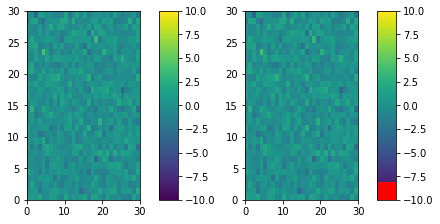

In [17]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
red = np.array([256/256, 0/256, 0/256, 1])
newcolors[:25, :] = red
newcmp = ListedColormap(newcolors)

print(newcolors)

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-10, vmax=10,)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples([viridis, newcmp])

In [4]:
class Spectrum:
    """
    Blah
    """
    def __init__(self, vals, dt, remove_dc=False, **kwargs):
        self.values = vals
        self.dt = dt
        self.n = len(vals)
        self.window = 'hann'
        self.remove_dc = remove_dc
        for k, v in kwargs.items():
            setattr(self, k, v)
        self._compute()

    def _compute(self):
        raw = self.values
        if self.remove_dc:
            raw -= np.mean(raw)
        if self.window == 'hann':
            raw *= np.sin(np.linspace(0, np.pi, self.n))
        cspec = fft(raw)[0:1 + self.n // 2]
        self._power = np.power(np.abs(cspec), 2)
        self._frequencies = np.linspace(0.0, 0.5 / self.dt, len(cspec))

    @property
    def power(self):
        return self._power

    @property
    def frequencies(self):
        return self._frequencies

    @property
    def velocities(self):
        return self._frequencies * 0.5 * 1550.0e-9

    @property
    def db(self):
        if hasattr(self, 'epsilon'):
            return np.log10(self._power + self.epsilon)
        return np.log10(self._power)

    def plot(self, use_db=True, against_v=True):
        x = (self.velocities,
             "v (m/s)") if against_v else (self.frequencies, "Frequency (Hz)")
        y = (self.db, "Power (dB)") if use_db else (self.power, "Power")
        plt.plot(x[0], y[0])
        plt.xlabel(x[1])
        plt.ylabel(y[1])
        plt.show()

In [2]:
class Spectrogram:
    """
    Representation of a photon Doppler velocimetry file.
    """

    def __init__(self, filename):
        """
        We assume that the first 1024 bytes of the file contain ascii text
        describing the data in the file. The first 512 bytes may vary, but
        the second 512-byte chunk should include (in order) the following:
            the number of samples
            the format (8, 16, or 32)
            the sample period (s)
            the start time
            the voltage step
            offset voltage
        """
        self.filename = filename
        self.path = os.path.realpath(filename)
        _, ext = os.path.splitext(filename)
        self.ext = ext.lower()[1:]
        # Let's declare all the fields we expect the Spectrogram to hold
        self.t0 = 0.0
        self.dt = 0.0
        self.V0 = 0.0
        self.dV = 0.0
        self.bits = 8
        self.samples = 0
        self.notes = dict()
        if self.digfile:
            self.load_dig_file()
        else:
            print(f"I don't understand files with extension {ext}")

    @property
    def digfile(self):
        return self.ext == 'dig'

    def load_dig_file(self):
        """
        A .dig file has a 1024-byte ascii header, typically followed by binary
        data. The first 512-byte segment has information specific to the
        particular device recording the data. The second 512-byte segment
        holds a list of values separated by carriage return-linefeed
        delimiters. The remaining space is padded with null bytes.
        """
        text = open(self.path, 'rb').read(1024).decode('ascii')
        top = [x.strip() for x in text[:512].replace(
            "\000", "").split('\r\n') if x.strip()]
        self.decode_dig_header(top)

        bottom = [x.strip() for x in text[512:].replace(
            "\000", "").split('\r\n') if x.strip()]
        self.headers = top

        # These fields are pretty short, but I think they're quite
        # descriptive. Do people think we should bulk them up?

        self.V0 = float(bottom[-1])  # voltage offset
        self.dV = float(bottom[-2])  # voltage interval
        self.t0 = float(bottom[-3])  # initial time
        self.dt = float(bottom[-4])  # sampling interval
        self.bits = int(bottom[-5])  # 8, 16, or 32
        self.samples = int(bottom[-6])
        self.bytes_per_point = self.bits // 8
        self.data_format = {1: np.uint8, 2: np.int16,
                            4: np.int32}[self.bytes_per_point]

        # We should pay attention to the endian-ness
        # We should probably adjust the datatype when we first decode the header,
        # rather than here. Can someone fix this?
        # Python stores the machine's endianess at sys.byteorder ('little'|'big')
        # The files we have seen so far are 'LSB', corresponding to 'little'
        # GEN3_CHANNEL1KEY001.dig header seems to have nothing about byte order
        if 'byte_order' in self.notes:
            native_order = 'MSB' if sys.byteorder == 'little' else 'LSB'
            if native_order != self.notes['byte_order']:
                self.data_format = np.dtype(
                    self.data_format).newbyteorder('S')  # swap the order

    def decode_dig_header(self, tList):
        """
        Maybe some help here?
        """
        instrument_spec_codes = {
            'BYT_N': 'binary_data_field_width',
            'BIT_N': 'bits',
            'ENC': 'encoding',
            'BN_F': 'number_format',
            'BYT_O': 'byte_order',
            'WFI': 'source_trace',
            'NR_P': 'number_pixel_bins',
            'PT_F': 'point_format',
            'XUN': 'x_unit',
            'XIN': 'x_interval',
            'XZE': 'post_trigger_seconds',
            'PT_O': 'pulse_train_output',
            'YUN': 'y_unit',
            'YMU': 'y_scale_factor',
            'YOF': 'y_offset',
            'YZE': 'y_component',
            'NR_FR': 'number_of_frames'
        }
        for line in tList:
            if any(s in line for s in instrument_spec_codes):
                for xstr in line.split(';'):
                    m = re.match(r'([^ ]*) (.*)', xstr)
                    if m and m.group(1) in instrument_spec_codes:
                        key, val = instrument_spec_codes[m.group(
                            1)], m.group(2)
                        # Attempt to decode the value
                        try:
                            val = int(val)  # can we convert to an integer?
                        except:
                            try:
                                # if not, can we convert to a float?
                                val = float(val)
                            except:
                                pass
                        # add the property to ourself
                        self.notes[key] = val
                        # print(f"{key} ==> {val}")

    def point_number(self, time):
        "Return the point number corresponding to the given time"
        return int((time - self.t0) / self.dt)

    def __str__(self):
        return "\n".join([
            self.filename,
            f"{self.bits} bits" + f" {self.notes['byte_order']} first" if 'byte_order' in self.notes else "",
            f"{self.t0*1e6} µs to {(self.t0 + self.dt*self.samples)*1e6} µs in steps of {self.dt*1e12} ps"
        ])

    def values(self, tStart, ending):
        """
        Return a numpy array with the properly normalized voltages corresponding to this segment.
        The ending argument can be an integer representing the number of points to include,
        or it can be a floating-point number indicating the ending time.
        """
        offset = 1024 if self.digfile else 0
        offset += self.bytes_per_point * self.point_number(tStart)
        if isinstance(ending, int):
            nSamples = ending
        else:
            nSamples = self.point_number(ending)
        with open(self.path, 'rb') as f:
            f.seek(offset)
            buff = f.read(nSamples * self.bytes_per_point)

        raw = np.frombuffer(buff, self.data_format, nSamples, 0)
        return raw * self.dV + self.V0

    def time_values(self, tStart, ending):
        """
        Return an array of time values corresponding to this interval. The arguments
        are the same as for the values method.
        """
        if isinstance(ending, int):
            nSamples = ending
            tFinal = tStart + (nSamples - 1) * self.dt
        else:
            tFinal = ending
            nSamples = 1 + int((tFinal - tStart) / self.dt)
        return np.linspace(tStart, tFinal, nSamples)

    def spectrum(self, t, nSamples, remove_dc=True):
        """
        Compute a spectrum from nSamples centered at time t
        """
        tStart = t - nSamples // 2 * self.dt
        if tStart < self.t0:
            tStart = self.t0
        raw = self.values(tStart, nSamples)
        return Spectrum(raw, self.dt, remove_dc)

    def spectrogram(self, tStart, tEnd, fftSize=1024, floor=1e-2):
        """
        Compute a spectrogram. This needs work!
        """
        freqs, times, spec = signal.spectrogram(
            x=self.values(tStart, tEnd),
            fs=(1.0 / self.dt),  # the sample frequency
            # ('tukey', 0.25),
            nperseg=fftSize,
            noverlap=None,
        )
        print(len(freqs))
        # Convert to a logarithmic representation and use floor to attempt
        # to suppress some noise.
        spec = 20 * np.log10(spec + floor)
        # scale the frequency axis to velocity
        velocities = freqs * 0.5 * 1550.e-9
        print(len(velocities))
        plt.pcolormesh(times, velocities, spec, cmap=plt.cm.hot, vmax=50)
        plt.ylabel('Velocity (m/s)')
        plt.xlabel('Time (s)')
        plt.show()
        print(velocities)
        print(times)
        print(spec)

GEN3CH_4_009.dig
8 bits LSB first
-200.0 µs to 1800.0 µs in steps of 20.0 ps
../For_Candace/dig/GEN1_CHAN1TEK001.dig
16 bits LSB first
-7.800019 µs to 192.19998099999998 µs in steps of 20.0 ps


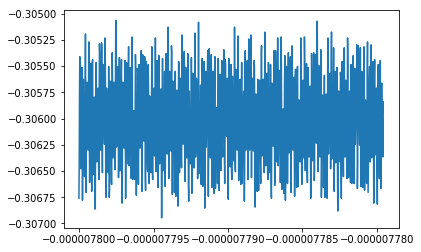

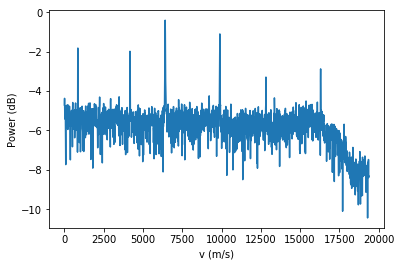

513
513


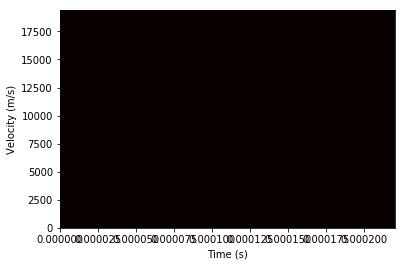

[    0.            37.84179688    75.68359375   113.52539062
   151.3671875    189.20898438   227.05078125   264.89257812
   302.734375     340.57617188   378.41796875   416.25976562
   454.1015625    491.94335938   529.78515625   567.62695312
   605.46875      643.31054688   681.15234375   718.99414062
   756.8359375    794.67773438   832.51953125   870.36132812
   908.203125     946.04492188   983.88671875  1021.72851562
  1059.5703125   1097.41210938  1135.25390625  1173.09570312
  1210.9375      1248.77929688  1286.62109375  1324.46289062
  1362.3046875   1400.14648438  1437.98828125  1475.83007812
  1513.671875    1551.51367188  1589.35546875  1627.19726562
  1665.0390625   1702.88085938  1740.72265625  1778.56445312
  1816.40625     1854.24804688  1892.08984375  1929.93164062
  1967.7734375   2005.61523438  2043.45703125  2081.29882812
  2119.140625    2156.98242188  2194.82421875  2232.66601562
  2270.5078125   2308.34960938  2346.19140625  2384.03320312
  2421.875       2459.71

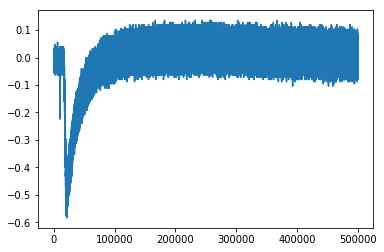

In [8]:
if __name__ == '__main__':
    s = Spectrogram(FILE)
    print(s)
    oth = Spectrogram('../For_Candace/dig/GEN1_CHAN1TEK001.dig')
    print(oth)
    plt.plot(oth.time_values(oth.t0, 1024), oth.values(oth.t0, 1024))
    plt.show()
    osp = oth.spectrum(0, 4096)
    osp.plot()

    s.spectrum(7e-6, 8192)
    s.spectrogram(5e-4, 2e-5, floor=1)
    vals = s.values(2.5e-6, 500000)
    plt.plot(vals)
    plt.show()